In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from easydict import EasyDict

def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = EasyDict(
        load_mel_from_disk=False,
        training_files='filelists/lj_audio_text_train_filelist.txt',
        validation_files='filelists/lj_audio_text_val_filelist.txt',
        text_cleaners=['english_cleaners'],

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=32768.0,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=512,
        mel_fmin=0.0,
        mel_fmax=8000.0,
        
        ################################
        # Model Parameters             #
        ################################
        n_symbols=256,
        symbols_embedding_dim=128,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=128,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-3,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        batch_size=4,
        mask_padding=True  # set model's padded outputs to padded values
    )

    return hparams


In [2]:
import numpy as np
from scipy.io.wavfile import read
import torch
import librosa

def text_to_utf8(text):
    utf = []
    for u in text.encode('utf-8'):
        utf.append(u)
        
    return np.array(utf).astype(int)

def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()
    return mask

# def load_wav_to_torch(full_path):
#     data, sampling_rate = librosa.core.load(full_path, sr=22050, mono=True)
#     data /= max(abs(data))
#     index = librosa.effects.trim(data, top_db=40, frame_length=1024, hop_length=256)[1]
#     start_index = index[0]
#     end_index = index[1] + int(22050 * 0.5)
#     data = data[start_index:end_index]
#     if end_index - len(data) > 0:
#         data = np.pad(data, (0, end_index - len(data)))
        
#     return torch.FloatTensor(data.astype(np.float32)), sampling_rate

def load_wav_to_torch(full_path):
    data, sampling_rate = librosa.core.load(full_path, sr=22050, mono=True)
    #data /= max(abs(data))
    #index = librosa.effects.trim(data, top_db=40, frame_length=1024, hop_length=256)[1]
    #data = data[index[0]:]
    
    data = np.concatenate([data, np.random.normal(loc=0.0, scale=1e-5, size=11025)])
    
    return data, sampling_rate 
    #return torch.FloatTensor(data.astype(np.float32)), sampling_rate

def load_filepaths_and_text(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        filepaths_and_text = [line.strip().split(split) for line in f]
    return filepaths_and_text


def to_gpu(x):
    x = x.contiguous()

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def make_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        Tensor: Mask tensor containing indices of padded part.
                dtype=torch.uint8 in PyTorch 1.2-
                dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[0, 0, 0, 0 ,0],
                 [0, 0, 0, 1, 1],
                 [0, 0, 1, 1, 1]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0],
                 [0, 0, 0, 0]],
                [[0, 0, 0, 1],
                 [0, 0, 0, 1]],
                [[0, 0, 1, 1],
                 [0, 0, 1, 1]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_pad_mask(lengths, xs, 1)
        tensor([[[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)
        >>> make_pad_mask(lengths, xs, 2)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

    """
    if length_dim == 0:
        raise ValueError('length_dim cannot be 0: {}'.format(length_dim))

    if not isinstance(lengths, list):
        lengths = lengths.tolist()
    bs = int(len(lengths))
    if xs is None:
        maxlen = int(max(lengths))
    else:
        maxlen = xs.size(length_dim)

    seq_range = torch.arange(0, maxlen, dtype=torch.int64)
    seq_range_expand = seq_range.unsqueeze(0).expand(bs, maxlen)
    seq_length_expand = seq_range_expand.new(lengths).unsqueeze(-1)
    mask = seq_range_expand >= seq_length_expand

    if xs is not None:
        assert xs.size(0) == bs, (xs.size(0), bs)

        if length_dim < 0:
            length_dim = xs.dim() + length_dim
        # ind = (:, None, ..., None, :, , None, ..., None)
        ind = tuple(slice(None) if i in (0, length_dim) else None
                    for i in range(xs.dim()))
        mask = mask[ind].expand_as(xs).to(xs.device)
    return mask


def make_non_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of non-padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        ByteTensor: mask tensor containing indices of padded part.
                    dtype=torch.uint8 in PyTorch 1.2-
                    dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[1, 1, 1, 1 ,1],
                 [1, 1, 1, 0, 0],
                 [1, 1, 0, 0, 0]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1],
                 [1, 1, 1, 1]],
                [[1, 1, 1, 0],
                 [1, 1, 1, 0]],
                [[1, 1, 0, 0],
                 [1, 1, 0, 0]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_non_pad_mask(lengths, xs, 1)
        tensor([[[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]]], dtype=torch.uint8)
        >>> make_non_pad_mask(lengths, xs, 2)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

    """
    return ~make_pad_mask(lengths, xs, length_dim)


In [3]:
import torch

class LinearNorm(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)


class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal


In [4]:
import sys
sys.path.append("espnet/egs/ljspeech/tts1/local")
sys.path.append("espnet")

from text.cleaners import custom_english_cleaners
from g2p_en import G2p

trans_type = "phn"
dict_path = "downloads/en/fastspeech/data/lang_1phn/phn_train_no_dev_units.txt"

with open(dict_path) as f:
    lines = f.readlines()
lines = [line.replace("\n", "").split(" ") for line in lines]
char_to_id = {c: int(i) for c, i in lines}
g2p = G2p()

def frontend(text, idim):
    """Clean text and then convert to id sequence."""
    text = custom_english_cleaners(text)
    
    if trans_type == "phn":
        text = filter(lambda s: s != " ", g2p(text))
        text = " ".join(text)
        #print(f"Cleaned text: {text}")
        charseq = text.split(" ")
    else:
        #print(f"Cleaned text: {text}")
        charseq = list(text)
    idseq = []
    for c in charseq:
        if c.isspace():
            idseq += [char_to_id["<space>"]]
        elif c not in char_to_id.keys():
            idseq += [char_to_id["<unk>"]]
        else:
            idseq += [char_to_id[c]]
    idseq += [idim - 1]  # <eos>
    #return torch.LongTensor(idseq).view(-1).to(device)
    return idseq


In [5]:
import random
import numpy as np
import torch
import torch.utils.data
import os

from os import listdir
from os.path import isfile, join
from librosa.filters import mel as librosa_mel_fn

def logmelfilterbank(audio,
                     sampling_rate,
                     fft_size=1024,
                     hop_size=256,
                     win_length=None,
                     window="hann",
                     num_mels=80,
                     fmin=None,
                     fmax=None,
                     eps=1e-10,
                     ):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(audio, n_fft=fft_size, hop_length=hop_size,
                          win_length=win_length, window=window, pad_mode="reflect")
    mag, phase = librosa.core.magphase(x_stft)
    phase_angle = np.angle(phase)
    phase_unwrapped = np.unwrap(phase_angle)
    dphase = phase_unwrapped[:, 1:] - phase_unwrapped[:, :-1]
    dphase = np.concatenate([phase_unwrapped[:, 0:1], dphase], axis=1)
    
    spec = np.stack([np.log10(np.maximum(eps, mag))[:512], dphase[:512]])
    # (2, F, T)
    return spec

def softmax_with_temperature(z, T=1, axis=0): 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axis=axis) 
    exp_z = np.exp(z - max_z) 
    sum_exp_z = np.sum(exp_z, axis=axis)
    y = exp_z / sum_exp_z
    
    return y

class TextMelLoader(torch.utils.data.Dataset):
    """
        1) loads audio,text pairs
        2) normalizes text and converts them to sequences of one-hot vectors
        3) computes mel-spectrograms from audio files.
    """
    def __init__(self, audiopaths_and_text, hparams):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)
        self.text_cleaners = hparams.text_cleaners
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.load_mel_from_disk = hparams.load_mel_from_disk
                
    def get_mel_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
        text, string = self.get_text(text)
        # (2, F, T)
        mel = self.get_mel(audiopath)
        #mel = (mel - np.log(1e-5)) / -np.log(1e-5)
        alignment = self.get_alignment(audiopath)
        
        return (text, mel, alignment, audiopath, string)
    
    def get_alignment(self, audiopath):
        import ntpath
        from scipy.special import softmax

        basename = ntpath.basename(audiopath)
        alignment = np.load('attention_lj/' + basename + '.npz')
        alignment = alignment['alignment']
        alignment = np.log(np.maximum(alignment, 1e-8))
        alignment = softmax_with_temperature(alignment, T=0.1, axis=0)

        return torch.FloatTensor(alignment)
    
    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            audio, sampling_rate = load_wav_to_torch(filename)
            # (F, T)
            melspec = logmelfilterbank(audio, 22050, fmin=80, fmax=7600)
            melspec = torch.FloatTensor(melspec.astype(np.float32))
            melspec = torch.autograd.Variable(melspec, requires_grad=False)
            
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels))
        
        return melspec

    def get_text(self, text):
        text_norm = torch.IntTensor(frontend(text, 256))
        #text_norm = torch.IntTensor(text_to_utf8(text))
        #text_norm = torch.IntTensor(text_to_sequence(text, self.text_cleaners))
        return text_norm, text

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)


class TextMelCollate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    def __init__(self):
        pass

    def __call__(self, batch):
        """Collate's training batch from normalized text and mel-spectrogram
        PARAMS
        ------
        batch: [text_normalized, mel_normalized, alignments, audiopath, strings]
        """
        # mel : [2, F, T]
        
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x[0]) for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]

        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][0]
            text_padded[i, :text.size(0)] = text

        # Right zero-pad mel-spec
        num_mels = batch[0][1].size(1)
        max_target_len = max([x[1].size(2) for x in batch])
        max_target_len = 1024

        # include mel padded
        mel_padded = torch.FloatTensor(len(batch), 2, num_mels, max_target_len)
        mel_padded.zero_()
        alignment_padded = torch.FloatTensor(len(batch), max_input_len, max_target_len)
        alignment_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        audio_paths = []
        strings = []
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][1]
            mel = torch.cat([mel, mel.flip(dims=[2])], dim=2)
            if mel.size(2) > max_target_len:
                mel = mel[:, :, :max_target_len]
            mel_padded[i, :, :, :mel.size(2)] = mel
            output_lengths[i] = mel.size(2)
            
            text = batch[ids_sorted_decreasing[i]][0]
            alignment = batch[ids_sorted_decreasing[i]][2]
            alignment = torch.cat([alignment, -alignment.flip(dims=[1])], dim=1)
            if alignment.size(1) > max_target_len:
                alignment = alignment[:, :max_target_len]
            alignment_padded[i, :text.size(0), :mel.size(2)] = alignment
            
            audio_paths.append(batch[ids_sorted_decreasing[i]][3])
            strings.append(batch[ids_sorted_decreasing[i]][4])
        
        outputs = {}
        outputs.update({"text_padded": text_padded})
        outputs.update({"input_lengths": input_lengths})
        outputs.update({"mel_padded": mel_padded})
        outputs.update({"output_lengths": output_lengths})
        outputs.update({"alignment_padded": alignment_padded})
        outputs.update({"audio_paths": audio_paths})
        outputs.update({"strings": strings})
        
        return outputs

In [6]:
from torch.utils.data import DataLoader

hparams = create_hparams()
for param in hparams:
    print(param, ':', hparams[param])
    
def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = None
    collate_fn = TextMelCollate()

    train_sampler = None

    train_loader = DataLoader(trainset, num_workers=1, shuffle=True,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

train_loader, valset, collate_fn = prepare_dataloaders(hparams)

load_mel_from_disk : False
training_files : filelists/lj_audio_text_train_filelist.txt
validation_files : filelists/lj_audio_text_val_filelist.txt
text_cleaners : ['english_cleaners']
max_wav_value : 32768.0
sampling_rate : 22050
filter_length : 1024
hop_length : 256
win_length : 1024
n_mel_channels : 512
mel_fmin : 0.0
mel_fmax : 8000.0
n_symbols : 256
symbols_embedding_dim : 128
encoder_kernel_size : 5
encoder_n_convolutions : 3
encoder_embedding_dim : 128
use_saved_learning_rate : False
learning_rate : 0.001
weight_decay : 1e-06
grad_clip_thresh : 1.0
batch_size : 4
mask_padding : True


In [7]:
from torch import nn
from torch.nn import functional as F

def squeeze2d(x):
    x1 = x[:, :, :, ::2]
    x2 = x[:, :, :, 1::2]
    y = torch.cat([x1, x2], dim=1)
    
    return y

def unsqueeze2d(x):
    def sparse_pad(x, even=True):
        b, c, h, w = x.size()
        x = x.unsqueeze(4)
        x = F.pad(x, (0, 1) if even else (1, 0))
        x = x.reshape(b, c, h, 2*w)
        
        return x
        
    c = x.size(1) // 2
    x1 = sparse_pad(x[:, :c])
    x2 = sparse_pad(x[:, c:], False)
    x = x1 + x2
    
    return x

def split(x):
    c = x.size(1) // 2
    y1 = x[:, :c]
    y2 = x[:, c:]
    
    return y1, y2
    
def merge(y1, y2):
    x = torch.cat([y1, y2], dim=1)
    
    return x

class Permutation2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        #W = torch.eye(c)
        self.W = nn.Parameter(W)
        self.W_inverse = None
        
    def forward(self, x):
        batch, channel, height, width = x.size()

        #log_det_W = torch.logdet(self.W)
        log_det_W = torch.slogdet(self.W)[1]
        dlog_det = height * width * log_det_W
        y = F.conv2d(x, self.W[:, :, None, None])

        return y, dlog_det
    
    def set_inverse(self):
        self.W_inverse = self.W.inverse()
        
    def inverse(self, y):
        x = F.conv2d(y, self.W_inverse[:, :, None, None])
        
        return x
    
class ConditionedConv2d(nn.Module):
    def __init__(self, in_channels, cond_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.c = out_channels
        self.filter_out = nn.Conv2d(in_channels=in_channels + cond_channels, out_channels=out_channels * 2, 
                              kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.filter_out.weight.data.normal_(0, 0.02)
                
    def forward(self, x, cond):
        # x: (B, C, H, W)
        # cond: (B, C, H, W)

        y = self.filter_out(torch.cat([x, cond], dim=1))
        y = F.tanh(y[:, :self.c]) * torch.sigmoid(y[:, self.c:])
        
        return y

class NonLinear2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        h = c * 32
        self.convs = nn.ModuleList([ConditionedConv2d(in_channels=c, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=3, stride=1, padding=1),
                                    ConditionedConv2d(in_channels=h, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=1, stride=1, padding=0)])
        self.last_conv = nn.Conv2d(in_channels=h, out_channels=c, kernel_size=3, stride=1, padding=1, bias=True)
        self.last_conv.weight.data.zero_()
        self.last_conv.bias.data.zero_()
        
    def forward(self, x, cond):
        # x: (B, C, H, W)
        # cond: (B, C, W)
        
        # (B, C, 1, W)
        cond = cond.unsqueeze(2)
        # (B, C, H, W)
        cond = cond.repeat(1, 1, x.size(2), 1)
        
        # (B, C, H, W)
        for i, conv in enumerate(self.convs):
            if i == 0:
                x = conv(x, cond)    
            else:
                x = x + conv(x, cond)
        x = self.last_conv(x)
        
        return x
    
class Flow2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.permutation = Permutation2d(2*c)
        self.non_linear = NonLinear2d(1*c)
        
    def forward(self, x, cond):

        # Permutation
        y, log_det_W = self.permutation(x)
        # Split
        y1, y2 = split(y)
        # Transform
        m = self.non_linear(y1, cond)
        y2 = y2 + m
        
        # Merge
        y = merge(y1, y2)
        # Log-Determinant
        log_det = log_det_W
        
        return y, log_det
    
    def set_inverse(self):
        self.permutation.set_inverse()
    
    def inverse(self, y, cond):
        # Split
        x1, x2 = split(y)
        # Inverse-Transform
        m = self.non_linear(x1, cond)
        x2 = x2 - m
        # Merge
        x = merge(x1, x2)
        # Inverse-Permutation
        x = self.permutation.inverse(x)
        
        return x
    
        
class SqueezeAndFlows2d(nn.Module):
    def __init__(self, c, num_flow):
        super().__init__()
        self.flows = nn.ModuleList([Flow2d(c) for _ in range(num_flow)])
        
    def forward(self, x, cond_list):
        y = squeeze2d(x)
        cond = None
        for _cond in cond_list:
            if _cond.size(2) == y.size(3):
                cond = _cond
        
        log_det = None
        for flow in self.flows:
            y, dlog_det = flow(y, cond)
            log_det = dlog_det if log_det is None else log_det + dlog_det
        
        channel = y.size(1)
        early_z = y[:, channel//2:]
        y = y[:, :channel//2]
        
        return y, log_det, early_z
    
    def set_inverse(self):
        for flow in self.flows:
            flow.set_inverse()
    
    def inverse(self, y, cond_list, alpha):
        x = torch.cat([y, torch.randn(*y.shape).cuda() * alpha], dim=1)
        cond = None
        for _cond in cond_list:
            if _cond.size(2) == x.size(3):
                cond = _cond
        
        for flow in reversed(self.flows):
            x = flow.inverse(x, cond)
        x = unsqueeze2d(x)
        
        return x

In [8]:
class Permutation1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        #W = torch.eye(c)
        self.W = nn.Parameter(W)
        
    def forward(self, x):
        batch, channel, time = x.size()

        log_det_W = torch.slogdet(self.W)[1]
        dlog_det = time * log_det_W
        y = F.conv1d(x, self.W[:, :, None])

        return y, dlog_det
        
    def set_inverse(self):
        self.W_inverse = self.W.inverse()
        
    def inverse(self, y):
        x = F.conv1d(y, self.W_inverse[:, :, None])
        
        return x

class ConditionedConv1d(nn.Module):
    def __init__(self, in_channels, cond_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.c = out_channels
        self.filter_out = nn.Conv1d(in_channels=in_channels+cond_channels, out_channels=out_channels*2, 
                              kernel_size=kernel_size, stride=stride, padding=padding, bias=False)      
        self.filter_out.weight.data.normal_(0, 0.02)
        
    def forward(self, x, cond):
        # x: (B, C, T)
        # cond: (B, C, T)
        y = self.filter_out(torch.cat([x, cond], dim=1))
        y = F.tanh(y[:, :self.c]) * torch.sigmoid(y[:, self.c:])
        
        return y
    
    
class NonLinear1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        h = c * 2
        self.convs = nn.ModuleList([ConditionedConv1d(in_channels=c, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=3, stride=1, padding=1),
                                    ConditionedConv1d(in_channels=h, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=1, stride=1, padding=0)])
        
        self.last_conv = nn.Conv1d(in_channels=h, out_channels=c, kernel_size=3, stride=1, padding=1, bias=True)
        self.last_conv.weight.data.zero_()
        self.last_conv.bias.data.zero_()
        
    def forward(self, x, cond):
        # x: (B, C, T)
        # cond: (B, C, T)
        
        # (B, C, T)
        for i, conv in enumerate(self.convs):
            if i == 0:
                x = conv(x, cond)
            else:
                x = x + conv(x, cond)
        
        x = self.last_conv(x)
        
        return x

class Flow1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.permutation = Permutation1d(c)
        self.non_linear = NonLinear1d(c//2)
        
    def forward(self, x, cond):

        # Permutation
        y, log_det_W = self.permutation(x)
        # Split
        y1, y2 = split(y)
        # Transform
        m = self.non_linear(y1, cond)
        y2 = y2 + m
        
        # Merge
        y = merge(y1, y2)
        # Log-Determinant
        log_det = log_det_W
        
        return y, log_det
    
    def set_inverse(self):
        self.permutation.set_inverse()
    
    def inverse(self, y, cond):
        # Split
        x1, x2 = split(y)
        # Inverse-Transform
        m = self.non_linear(x1, cond)
        x2 = x2 - m
        # Merge
        x = merge(x1, x2)
        # Inverse-Permutation
        x = self.permutation.inverse(x)
        
        return x
    
class ReshapeAndFlows1d(nn.Module):
    def __init__(self, c, num_flow):
        super().__init__()
        self.flows = nn.ModuleList([Flow1d(c) for _ in range(num_flow)])
        
    def forward(self, x, cond_list):

        cond = None
        for _cond in cond_list:
            if _cond.size(2) == x.size(3):
                cond = _cond
        batch, channel, height, width = x.size()        
        y = x.reshape(batch, channel * height, width)

        log_det = None
        for flow in self.flows:
            y, dlog_det = flow(y, cond)
            log_det = dlog_det if log_det is None else log_det + dlog_det
        
        y = y.reshape(batch, channel, height, width)
        early_z = y[:, :, height//2:]
        y = y[:, :, :height//2]
        
        return y, log_det, early_z
    
    def set_inverse(self):
        for flow in self.flows:
            flow.set_inverse()
    
    def inverse(self, y, cond_list, alpha):
        cond = None
        for _cond in cond_list:
            if _cond.size(2) == y.size(3):
                cond = _cond
                
        y = torch.cat([y, torch.randn(*y.shape).cuda() * alpha], dim=2)
        batch, channel, height, width = y.size()        
        x = y.reshape(batch, channel * height, width)
        
        for flow in reversed(self.flows):
            x = flow.inverse(x, cond)
            
        x = x.reshape(batch, channel, height, width)
        return x

In [9]:
class Encoder(nn.Module):
    """Encoder module:
        - Three 1-d convolution banks
        - Bidirectional LSTM
    """
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        convolutions = []
        for _ in range(hparams.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                ConvNorm(hparams.encoder_embedding_dim,
                         hparams.encoder_embedding_dim,
                         kernel_size=hparams.encoder_kernel_size, stride=1,
                         padding=int((hparams.encoder_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(hparams.encoder_embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                            int(hparams.encoder_embedding_dim / 2), 1,
                            batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        for conv in self.convolutions:
            x = F.relu(conv(x))

        x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(
            x, input_lengths, batch_first=True)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(
            outputs, batch_first=True)

        return outputs.transpose(1, 2)

    def inference(self, x):
        for conv in self.convolutions:
            x = F.relu(conv(x))

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs.transpose(1, 2)
    
class Pooling(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.convs = nn.ModuleList([ConvNorm(hparams.encoder_embedding_dim, hparams.encoder_embedding_dim,
                                             kernel_size=3, stride=2, padding=1, dilation=1, w_init_gain='relu') for _ in range(4)])
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hparams.encoder_embedding_dim) for _ in range(4)])
        
    def forward(self, x):
        outputs = [x]
        for batch_norm, conv in zip(self.batch_norms, self.convs):
            x = conv(x)
            outputs.append(x)
            x = F.relu(batch_norm(x))
            
        return outputs

In [10]:
from math import sqrt

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(hparams)
        self.embedding = nn.Embedding(
            hparams.n_symbols, hparams.symbols_embedding_dim)
        std = sqrt(2.0 / (hparams.n_symbols + hparams.symbols_embedding_dim))
        val = sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        self.pooling = Pooling(hparams)
        
        depth = 4
        modules = [] 
        modules.append(ReshapeAndFlows1d(1024, depth))
        modules.append(ReshapeAndFlows1d(512, depth))
        modules.append(SqueezeAndFlows2d(2, depth))
        
        modules.append(ReshapeAndFlows1d(256, depth))
        modules.append(ReshapeAndFlows1d(128, depth))
        modules.append(SqueezeAndFlows2d(2, depth))
        
        modules.append(ReshapeAndFlows1d(64, depth))
        modules.append(ReshapeAndFlows1d(32, depth))
        modules.append(SqueezeAndFlows2d(2, depth))
                
        self.squeeze_and_flows_list = nn.ModuleList(modules)
        
    def forward(self, batch):
        # texts: (B, N)
        # mels: (B, C=1, H=80, W=1024)
        # alignments: (B, N, T)
        
        # (B, C, N)
        embedded_inputs = self.embedding(batch["text_padded"]).transpose(1, 2)
        # (B, C, N)
        encoder_outputs = self.encoder(embedded_inputs, batch["input_lengths"])
        # (B, N, T)
        alignments = batch['alignment_padded']
        # (B, C, T)
        input_contexts = torch.bmm(encoder_outputs, alignments)
        # (B, C, T), (B, C, T//2), (B, C, T//4), (B, C, T//8), (B, C, T//16)
        input_contexts_list = self.pooling(input_contexts)
        
        y = batch['mel_padded']
        zs = []
        log_det = None
        for i, squeeze_and_flows in enumerate(self.squeeze_and_flows_list):
            y, dlog_det, early_z = squeeze_and_flows(y, input_contexts_list)
            log_det = dlog_det if log_det is None else log_det + dlog_det
            zs.append(early_z)
            
        zs.append(y)
        
        return zs, log_det
    
    def set_inverse(self):
        for module in self.squeeze_and_flows_list:
            module.set_inverse()
    
    def inverse(self, text, alignments, width=1024, alpha=1.0):
        
        embedded_inputs = self.embedding(text).transpose(1, 2)
        encoder_outputs = self.encoder.inference(embedded_inputs)
        input_contexts = torch.bmm(encoder_outputs, alignments)
        input_contexts_list = self.pooling(input_contexts)

        base_width = width // 8
        x = torch.randn(1, 2, 8, base_width).cuda() * alpha
        
        layer = 0
        for squeeze_and_flows in reversed(self.squeeze_and_flows_list):
            x = squeeze_and_flows.inverse(x, input_contexts_list, alpha)
            layer = layer + 1
            
        return x
    
    def loss(self, zs, log_det):
        
        lls = None
        dim = 0
        for z in zs:
            dim += z.size(1) * z.size(2) * z.size(3)
            ll = torch.sum(-0.5 * (np.log(2 * np.pi) + z ** 2), dim=(1, 2, 3))
            lls = ll if lls is None else lls + ll
        
        log_likelihood = lls + log_det
        loss = torch.mean(-log_likelihood / dim)
        
        return loss

In [11]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/flowent-lj512-if'
#!rm -rf $save_dir
logger = Logger(save_dir)

!ls $save_dir

events.out.tfevents.1589195088.scpark-X299-WU8	save_0
events.out.tfevents.1589195174.scpark-X299-WU8


Model size 201.7MiB
done


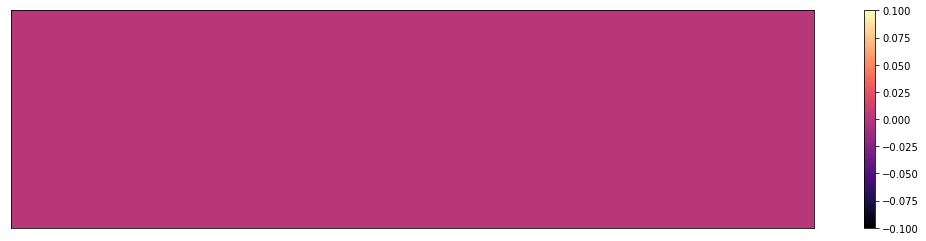

In [12]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
import time
import torch.distributed as dist

def get_save_path(save_dir, step):
    return save_dir + '/' + 'save_' + str(step)

step = 0
GPU = 0

model = Model()
model.cuda(GPU)

def sizeof_fmt(num, suffix='B'):
    """
    Given `num` bytes, return human readable size.
    Taken from https://stackoverflow.com/a/1094933
    """
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

path = get_save_path(save_dir, step)
if os.path.exists(path) and False:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.lr
    except:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    step = checkpoint['step']
    step += 1
    print('loaded')

print('done')

plt.figure(figsize=[18, 4])
librosa.display.specshow(np.zeros([100, 100]))
plt.colorbar()
plt.show()


In [13]:
def to_gpu(batch):
    batch['text_padded'] = batch['text_padded'].cuda()
    batch['input_lengths'] = batch['input_lengths'].cuda()
    batch['mel_padded'] = batch['mel_padded'].cuda()
    batch['mel_padded'] = batch['mel_padded']
    batch['output_lengths'] = batch['output_lengths'].cuda()
    batch['alignment_padded'] = batch['alignment_padded'].cuda()
    
    return batch

In [ ]:
import time

model.train()

while(True):
    for i, batch in enumerate(train_loader):
        t0 = time.time()
        
        batch = to_gpu(batch)
        model.zero_grad()
        z, log_det = model(batch)
        
        loss = model.loss(z, log_det)
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        t1 = time.time()
        print('step:', step, 'loss:', loss.item(), 'elapsed time:', t1 - t0)
        t0 = time.time()

        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = get_save_path(save_dir, step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
        
        if i % 100 == 0:
            clear_output() 
            
            _alignments = batch["alignment_padded"].data.cpu().numpy()
            batch_size = _alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(2):
                plt.subplot(1, 2, i+1)
                plt.imshow(_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            length = batch['output_lengths'][0].item()
            #length = 1024
            
            plt.figure(figsize=[18, 3])
            librosa.display.specshow(batch['mel_padded'][0, 0, :, :].data.cpu().numpy())
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            librosa.display.specshow(batch['mel_padded'][0, 1, :, :].data.cpu().numpy())
            plt.colorbar()
            plt.show()
            
            width = 1024
            model.set_inverse()
            img_gen = model.inverse(batch['text_padded'][:1], batch['alignment_padded'][:1], width, alpha=0.8)
            _img_gen = img_gen.data.cpu().numpy()
            #_img_gen = np.clip(_img_gen, -5, 0)
            
            plt.figure(figsize=[18, 3])
            librosa.display.specshow(_img_gen[0, 0, :, :])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            librosa.display.specshow(_img_gen[0, 1, :, :])
            plt.colorbar()
            plt.show()
            
            print(batch['strings'][0])
        
        step += 1
        

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
path = get_save_path(save_dir, step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)


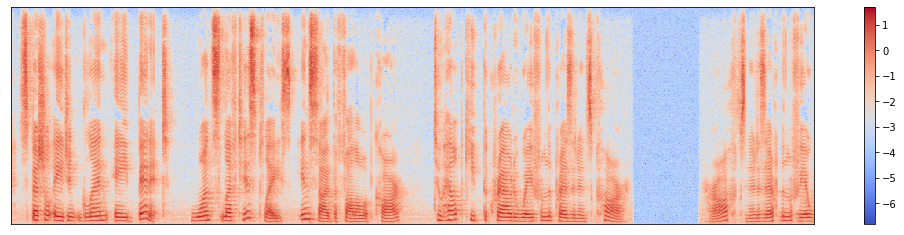

0.05741111437479655


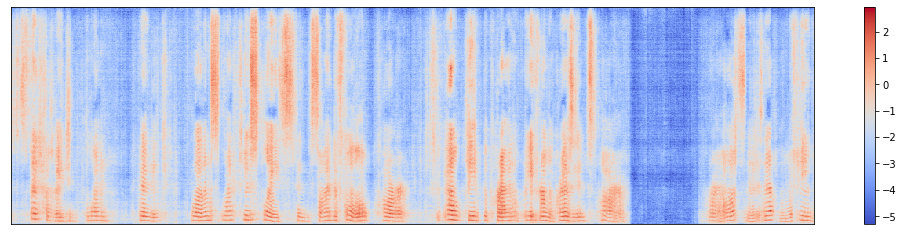

In [32]:
plt.figure(figsize=[18, 4])
librosa.display.specshow(batch['mel_padded'][0, 0].data.cpu().numpy())
plt.colorbar()
plt.show()

model.eval()
model.set_inverse()
times = []
for _ in range(3):
    t0 = time.time()
    img_gen = model.inverse(batch['text_padded'][:1], batch['alignment_padded'][:1], 1024, alpha=0.7)
    t1 = time.time()
    times.append(t1 - t0)
print(np.mean(times))
_img_gen = img_gen.data.cpu().numpy()[0, 0]

plt.figure(figsize=[18, 4])
librosa.display.specshow(_img_gen)
plt.colorbar()
plt.show()

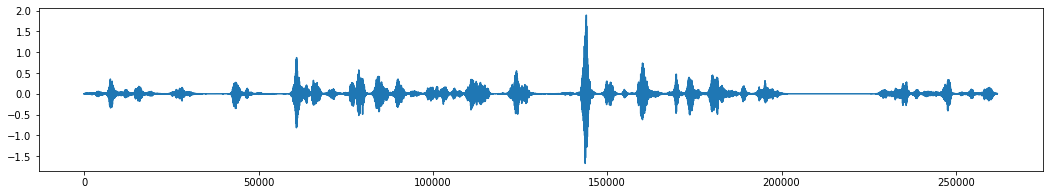

In [33]:
mag, dphase = img_gen[0, 0].data.cpu().numpy(), img_gen[0, 1].data.cpu().numpy()
accum = np.add.accumulate(dphase, axis=1)
C_t = (10 ** mag) * np.exp(1j * accum) 
recon = librosa.core.istft(C_t, hop_length=256)
plt.figure(figsize=[18, 3])
plt.plot(recon)
plt.show()

import IPython.display as ipd
ipd.Audio(recon, rate=22050)

In [ ]:
import scipy 

def mel_to_wave(mel):
    # mel : [T, C]
    
    def dynamic_range_decompression(y, lower_bound=1e-5):

        return 10 ** y
    
    mel = dynamic_range_decompression(mel)
    print(mel.shape)
    spec = np.concatenate([mel, np.zeros([1, mel.shape[1]])], axis=0)
    
    wave = librosa.core.griffinlim(spec, n_iter=120, hop_length=hparams.hop_length)
    return wave

wave = mel_to_wave(_img_gen)
wave = np.clip(wave, -1, 1)
plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()
 
print(batch['strings'][0])

import IPython.display as ipd
ipd.Audio(wave, rate=22050)



(512, 1024)


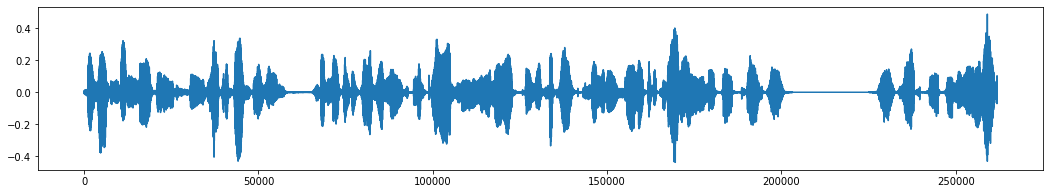

In [24]:
wave = mel_to_wave(batch['mel_padded'][0, 0].data.cpu().numpy())

plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)

In [102]:
from scipy.special import softmax

data = np.load('alignment-kss-asym-example/example.npz')
texts = torch.from_numpy(data['text'][None, :]).long().cuda()
print(texts.shape)

alignment = data['alignment']
alignment = np.log(np.maximum(alignment, 1e-8))
alignment = softmax(alignment, axis=0)
print(alignment.shape)
alignments = torch.from_numpy(alignment[None, :]).cuda().float()
alignments = torch.cat([alignments, -alignments.flip(dims=[2])], dim=2)
print(alignments.shape)

alignments = F.pad(alignments, (0, 1024 - alignments.size(2)))
print('alignments ', alignments.shape)

model.eval()
times = []
for _ in range(20):
    t0 = time.time()
    with torch.no_grad():
        img_gen = model.inverse(texts, alignments, 1024, alpha=0.7)
    torch.cuda.synchronize()
    t1 = time.time()
    times.append(t1 - t0)
print(np.mean(times))
_img_gen = img_gen.data.cpu().numpy()
print(_img_gen.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(_img_gen[0, 0, :alignment.shape[1]])
plt.colorbar()
plt.show()

wave = mel_to_wave(_img_gen[0, 0, :alignment.shape[1]])
plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)


FileNotFoundError: [Errno 2] No such file or directory: 'alignment-kss-asym-example/example.npz'

### From File

torch.Size([1, 91])
(91, 763)
torch.Size([1, 91, 1526])
alignments  torch.Size([1, 91, 1024])


/home/rubato/anaconda3/envs/floent/lib/python3.8/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.9406092166900635
(384, 763)


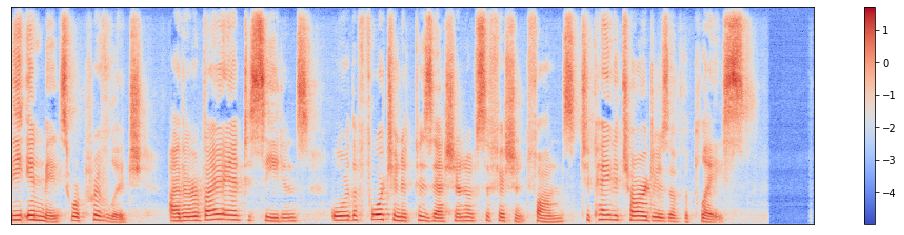

(384, 763)


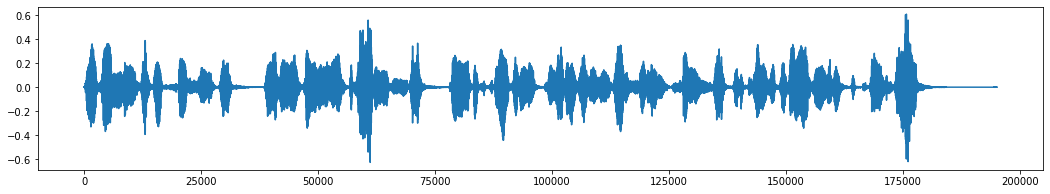

Redpath was called in and informed of the intended investigation. He tried to stave off the evil hour by declaring that everything was perfectly right.


In [42]:
from scipy.special import softmax

data = np.load('alignment-lj-example/example.npz')
texts = torch.from_numpy(data['text'][None, :]).long().cuda()
print(texts.shape)

alignment = data['alignment']
alignment = np.log(np.maximum(alignment, 1e-8))
alignment = softmax_with_temperature(alignment, T=0.1, axis=0)
print(alignment.shape)
length = alignment.shape[1]
alignments = torch.from_numpy(alignment[None, :]).cuda().float()
alignments = torch.cat([alignments, -alignments.flip(dims=[2])], dim=2)
print(alignments.shape)

alignments = F.pad(alignments, (0, 1024 - alignments.size(2)))
print('alignments ', alignments.shape)

model.eval()
times = []
for _ in range(2):
    t0 = time.time()
    with torch.no_grad():
        img_gen = model.inverse(texts, alignments, 1024, alpha=0.7)
    torch.cuda.synchronize()
    t1 = time.time()
    times.append(t1 - t0)
print(np.mean(times))
_img_gen = img_gen.data.cpu().numpy()[0, 0, :, :length]
print(_img_gen.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(_img_gen)
plt.colorbar()
plt.show()

wave = mel_to_wave(_img_gen)
plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

print("Redpath was called in and informed of the intended investigation. He tried to stave off the evil hour by declaring that everything was perfectly right.")
import IPython.display as ipd
ipd.Audio(wave, rate=22050)


### Parallel WaveGAN

In [40]:
from parallel_wavegan.utils import read_hdf5
from sklearn.preprocessing import StandardScaler

stats_filename = "ParallelWaveGAN/pretrain_model/stats.h5"
scaler = StandardScaler()
scaler.mean_ = read_hdf5(stats_filename, 'mean')
scaler.scale_ = read_hdf5(stats_filename, 'scale')

In [41]:
import torch
import yaml
import sys
sys.path.append("ParallelWaveGAN")

import parallel_wavegan.models

config = 'ParallelWaveGAN/pretrain_model/config.yml'
checkpoint = 'ParallelWaveGAN/pretrain_model/checkpoint-3000000steps.pkl'
device = 'cuda'

with open(config) as f:
    config = yaml.load(f, Loader=yaml.Loader)

model_class = getattr(
        parallel_wavegan.models,
        config.get("generator_type", "ParallelWaveGANGenerator"))
vocoder_model = model_class(**config["generator_params"])
vocoder_model.load_state_dict(
    torch.load(checkpoint, map_location="cpu")["model"]["generator"])

vocoder_model.remove_weight_norm()
vocoder_model = vocoder_model.eval().to(device)
use_noise_input = not isinstance(
    vocoder_model, parallel_wavegan.models.MelGANGenerator)
pad_fn = torch.nn.ReplicationPad1d(
    config["generator_params"].get("aux_context_window", 0))

In [42]:
print(batch['strings'][0])

Ikey left no traces, and the police could hear nothing of him. He had in fact gone out of the country, to Copenhagen, whence he passed on to New York.


In [35]:
# start generation
with torch.no_grad():
    condition = scaler.transform(_img_gen.T)
    x = ()
    if use_noise_input:
        z = torch.randn(1, 1, len(condition) * config["hop_size"]).to(device)
        x += (z,)
    condition = pad_fn(torch.from_numpy(condition).unsqueeze(0).transpose(2, 1)).to(device)
    x += (condition,)

    # generate
    y = vocoder_model(*x).view(-1).cpu().numpy()

plt.figure(figsize=[18, 3])
plt.plot(y)
plt.show()

import IPython.display as ipd
ipd.Audio(y, rate=22050)    

NameError: name 'scaler' is not defined